In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

import statsmodels.formula.api as smf

import requests as re

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split

sns.set_context('poster')
sns.set_style('whitegrid')

In [75]:
df = pd.read_json('train_data.json')

In [77]:
# Drop index and level_0 because we are told to ignore them
df = df.drop(['index', 'level_0'], axis=1)
df.columns

Index(['Balcony', 'Cats Allowed', 'Common Outdoor Space', 'Dining Room',
       'Dishwasher', 'Dogs Allowed', 'Doorman', 'Elevator', 'Exclusive',
       'Fitness Center', 'Garden/Patio', 'Hardwood Floors',
       'High Speed Internet', 'Laundry In Building', 'Laundry in Building',
       'Laundry in Unit', 'Loft', 'New Construction', 'No Fee',
       'Outdoor Space', 'Pre-War', 'Roof Deck', 'Swimming Pool', 'Terrace',
       'Wheelchair Access', 'bathrooms', 'bedrooms', 'building_id', 'created',
       'description', 'display_address', 'features', 'interest_level',
       'latitude', 'listing_id', 'longitude', 'manager_id', 'photos', 'price',
       'street_address'],
      dtype='object')

Things to think about grouping
1. cats allowed / dogs allowed
2. doorman / exclusive
3. balcony / common outdoor space / garden/patio / roof deck / terrace
4. fitness center / swimming pool
5. 

In [4]:
df.interest_level.value_counts()

low       29147
medium     9491
high       3280
Name: interest_level, dtype: int64

In [5]:
test = pd.read_json('test_data.json')

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7434 entries, 0 to 999
Data columns (total 41 columns):
Balcony                 7434 non-null int64
Cats Allowed            7434 non-null int64
Common Outdoor Space    7434 non-null int64
Dining Room             7434 non-null int64
Dishwasher              7434 non-null int64
Dogs Allowed            7434 non-null int64
Doorman                 7434 non-null int64
Elevator                7434 non-null int64
Exclusive               7434 non-null int64
Fitness Center          7434 non-null int64
Garden/Patio            7434 non-null int64
Hardwood Floors         7434 non-null int64
High Speed Internet     7434 non-null int64
Laundry In Building     7434 non-null int64
Laundry in Building     7434 non-null int64
Laundry in Unit         7434 non-null int64
Loft                    7434 non-null int64
New Construction        7434 non-null int64
No Fee                  7434 non-null int64
Outdoor Space           7434 non-null int64
Pre-War       

In [3]:
# See if two laundry in buildings are the same
df['Laundry In Building'].value_counts()

0    39710
1     2208
Name: Laundry In Building, dtype: int64

In [4]:
# See if two laundry in buildings are the same
df['Laundry in Building'].value_counts()

0    28025
1    13893
Name: Laundry in Building, dtype: int64

In [5]:
def combine_laundry(col1, col2):
    if col1 != 0:
        return col1
    else:
        return col2

In [81]:
# Aggregate to create one laundry in building column that isn't case sensitive
df['laundry_in_building'] = df.apply(lambda row: combine_laundry(row['Laundry in Building'], row['Laundry In Building']), axis=1)

# Drop old laundry in building columns
df = df.drop(['Laundry in Building', 'Laundry In Building'], axis=1)

In [82]:
def interestValues(x):
    if 'low' in x:
        return 0
    elif 'med' in x:
        return .5
    else:
        return 1

In [83]:
df['interestVal'] = df['interest_level'].apply(interestValues)

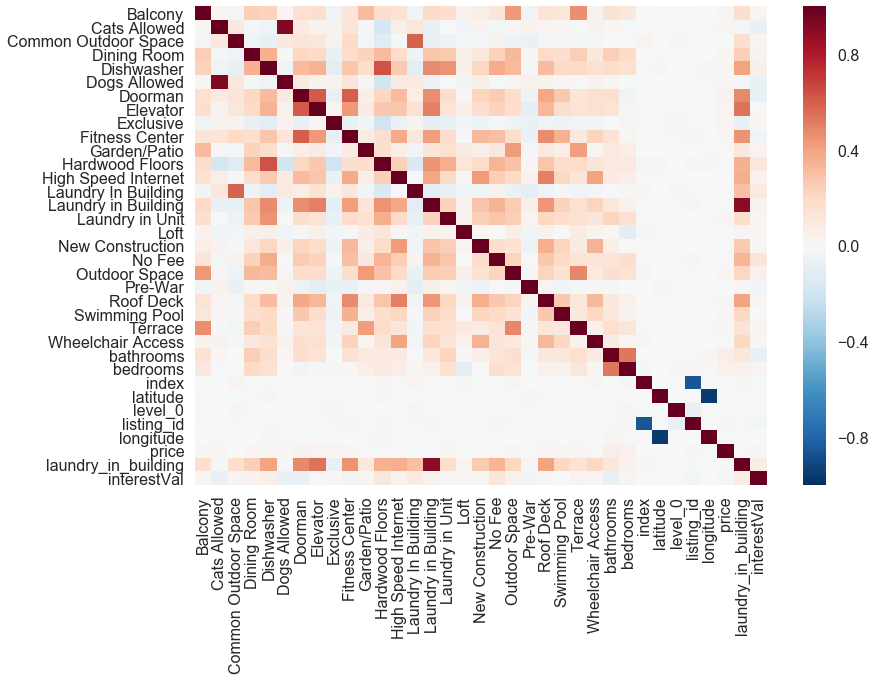

In [35]:
# Correlation Matrix of Data
sns.heatmap(df.corr())

In [13]:
df.interest_level.value_counts()

low       29147
medium     9491
high       3280
Name: interest_level, dtype: int64

In [14]:
df.interestVal.value_counts()

0.0    29147
0.5     9491
1.0     3280
Name: interestVal, dtype: int64

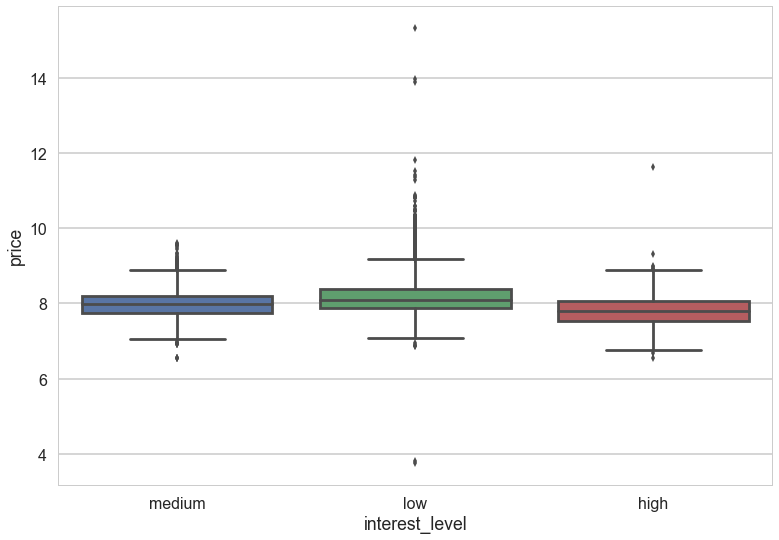

In [15]:
# Side by Side Box Plot of log(Price) vs. High, Medium, and Low Interest
sns.boxplot(x=df['interest_level'], y=df['price'].apply(np.log))

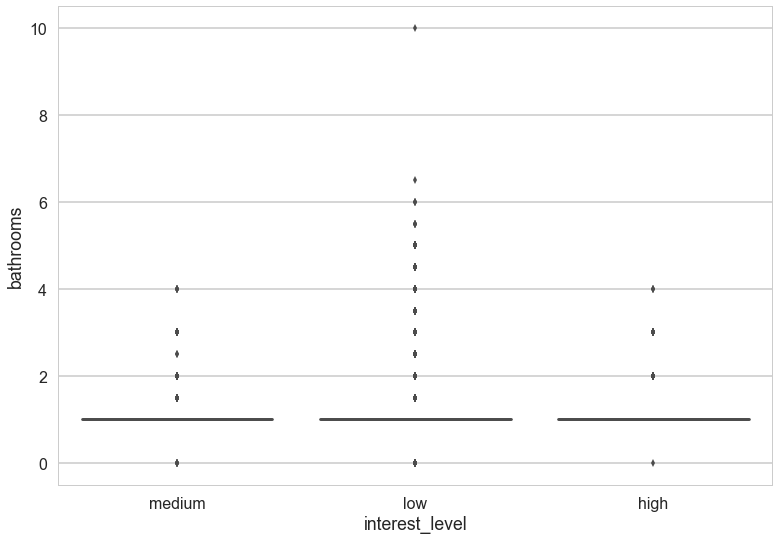

In [16]:
# Side by Side Box Plot of Bathrooms vs. High, Medium, and Low Interest
sns.boxplot(x=df['interest_level'], y=df['bathrooms'])

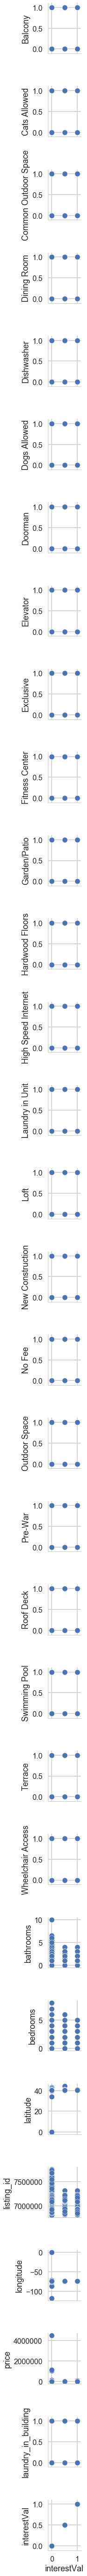

In [84]:
# See if we can get spread of interest level by different predictors
cols = df.select_dtypes(include=['float64', 'int64']).columns
sns.pairplot(df, x_vars=['interestVal'], y_vars=cols)
plt.savefig('interestLevelPairwise.png')

In [85]:
# Create interaction term for cats and dogs allowed
df['pets_allowed'] = df['Cats Allowed'] * df['Dogs Allowed']

In [86]:
# Create interaction term for doorman/exclusive
df['door_excl'] = df['Doorman'] * df['Exclusive']

In [87]:
# Create interaction term for fitness oriented
df['fitness_oriented'] = df['Fitness Center'] * df['Swimming Pool']

In [88]:
# Create transformed term that creates a score for outdoor spaces
df['outdoor_score'] = (df['Outdoor Space'] + df['Balcony'] + df['Common Outdoor Space'] + df['Garden/Patio'] + df['Roof Deck'] + df['Terrace']) / 6

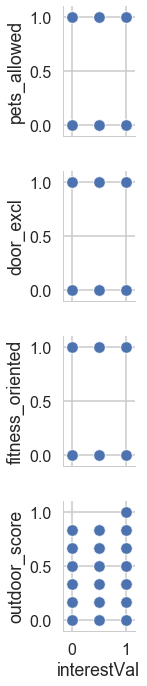

In [89]:
# Interest level vs. new interaction terms
sns.pairplot(df, x_vars=['interestVal'], y_vars=['pets_allowed', 'door_excl', 'fitness_oriented', 'outdoor_score'])

Only high interest listings have all 6 outdoor features.  So if a listing does not have a balcony, common outdoor space, garden/patio, roof deck, or terrace, then we know it is not high interest.

In [90]:
# ADA compatible interaction term
df['ada'] = df['Elevator'] * df['Wheelchair Access']

In [91]:
# Luxury Score Term
df['lux_score'] = (df['Exclusive'] + df['Doorman'] + df['Outdoor Space'] + df['New Construction'] + df['Roof Deck'] + df['Fitness Center'] + df['Swimming Pool'] + df['Elevator'] + df['Laundry in Unit'] + df['Hardwood Floors']) / 10

In [92]:
def count_features(feats):
    return len(feats)

In [93]:
# Number of Features per Listing
df['num_features'] = df['features'].apply(lambda x: count_features(x))

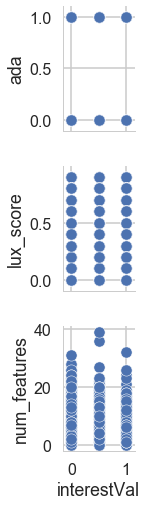

In [94]:
# Interest level vs. new interaction terms
sns.pairplot(df, x_vars=['interestVal'], y_vars=['ada', 'lux_score', 'num_features'])

It is interesting that a higher number of features doesn't seem to indicate more interest.  The highest number of features indicate medium amount of interest.

In [95]:
df.columns

Index(['Balcony', 'Cats Allowed', 'Common Outdoor Space', 'Dining Room',
       'Dishwasher', 'Dogs Allowed', 'Doorman', 'Elevator', 'Exclusive',
       'Fitness Center', 'Garden/Patio', 'Hardwood Floors',
       'High Speed Internet', 'Laundry in Unit', 'Loft', 'New Construction',
       'No Fee', 'Outdoor Space', 'Pre-War', 'Roof Deck', 'Swimming Pool',
       'Terrace', 'Wheelchair Access', 'bathrooms', 'bedrooms', 'building_id',
       'created', 'description', 'display_address', 'features',
       'interest_level', 'latitude', 'listing_id', 'longitude', 'manager_id',
       'photos', 'price', 'street_address', 'laundry_in_building',
       'interestVal', 'pets_allowed', 'door_excl', 'fitness_oriented',
       'outdoor_score', 'ada', 'lux_score', 'num_features'],
      dtype='object')

In [96]:
print(type(df.select_dtypes(include=['float64', 'int64'])))

<class 'pandas.core.frame.DataFrame'>


In [97]:
# Split into a training and a test set from training data
reduced_df = df.select_dtypes(include=['float64', 'int64'])

# Rename terms to use stat models OLS
reduced_df = reduced_df.rename(columns={
    'Cats Allowed':'Cats_Allowed',
    'Common Outdoor Space':'Common_Outdoor_Space',
    'Dining Room':'Dining_Room',
    'Dogs Allowed':'Dogs_Allowed',
    'Fitness Center':'Fitness_Center',
    'Garden/Patio':'Garden_Patio',
    'Hardwood Floors':'Hardwood_Floors',
    'High Speed Internet':'High_Speed_Internet',
    'Laundry in Unit':'Laundry_In_Unit',
    'New Construction':'New_Construction',
    'No Fee':'No_Fee',
    'Outdoor Space':'Outdoor_Space',
    'Pre-War':'Pre_War',
    'Roof Deck':'Roof_Deck',
    'Swimming Pool':'Swimming_Pool',
    'Wheelchair Access':'Wheelchair_Access',
})

X_tr, X_test, Y_tr, Y_test = train_test_split(reduced_df, df['interestVal'], test_size=0.3, random_state=42)

In [98]:
X_tr.columns

Index(['Balcony', 'Cats_Allowed', 'Common_Outdoor_Space', 'Dining_Room',
       'Dishwasher', 'Dogs_Allowed', 'Doorman', 'Elevator', 'Exclusive',
       'Fitness_Center', 'Garden_Patio', 'Hardwood_Floors',
       'High_Speed_Internet', 'Laundry_In_Unit', 'Loft', 'New_Construction',
       'No_Fee', 'Outdoor_Space', 'Pre_War', 'Roof_Deck', 'Swimming_Pool',
       'Terrace', 'Wheelchair_Access', 'bathrooms', 'bedrooms', 'latitude',
       'listing_id', 'longitude', 'price', 'laundry_in_building',
       'interestVal', 'pets_allowed', 'door_excl', 'fitness_oriented',
       'outdoor_score', 'ada', 'lux_score', 'num_features'],
      dtype='object')

In [104]:
#TODO
linReg = X_tr.select_dtypes(exclude=['object'])
# print(linReg.columns)
equation = ('+').join(linReg.drop(['listing_id'], axis=1).columns)
model = smf.ols('interestVal~'+equation, data=X_tr).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            interestVal   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.359e+26
Date:                Mon, 20 Nov 2017   Prob (F-statistic):               0.00
Time:                        00:06:12   Log-Likelihood:             8.0131e+05
No. Observations:               29342   AIC:                        -1.603e+06
Df Residuals:                   29306   BIC:                        -1.602e+06
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             2.054e-15   1.11e-13      0.018      0.985   -2.16e-13    2.21e-13
Balcony               1.081e-12   9.69e-15    111.504      0.000    1.06e-12     1.1e-12
Cats_Allowed          4.801e-14   1.16e-14      4.156      0.000    2.54e-14    7.07e-14
Common_Outdoor_Space -3.925e-13    1.3e-14    -30.166      0.000   -4.18e-13   -3.67e-13
Dining_Room          -1.578e-13   7.44e-15    -21.204      0.000   -1.72e-13   -1.43e-13
Dishwasher            2.814e-14   5.92e-15      4.757      0.000    1.65e-14    3.97e-14
Dogs_Allowed          1.099e-13    6.7e-14      1.641      0.101   -2.14e-14    2.41e-13
Doorman              -8.027e-14      6e-15    -13.380      0.000    -9.2e-14   -6.85e-14
Elevator              1.093e-13   5.62e-15     19.443      0.000    9.83e-14     1.2e-13
Exclusive             1.745e-13   1.11e-14     15.710      0.000    1.53e-13    1.96e-13
Fitness_Center        7.181e-15   6.54e-15      1.099      0.272   -5.63e-15       2e-14
Garden_Patio         -3.195e-13   1.16e-14    -27.579      0.000   -3.42e-13   -2.97e-13
Hardwood_Floors      -1.767e-13   5.53e-15    -31.939      0.000   -1.88e-13   -1.66e-13
High_Speed_Internet  -3.465e-14   8.98e-15     -3.859      0.000   -5.22e-14    -1.7e-14
Laundry_In_Unit        3.17e-13   6.14e-15     51.635      0.000    3.05e-13    3.29e-13
Loft                 -2.175e-13      1e-14    -21.688      0.000   -2.37e-13   -1.98e-13
New_Construction      6.579e-14   1.03e-14      6.365      0.000    4.55e-14     8.6e-14
No_Fee                6.152e-14   4.97e-15     12.389      0.000    5.18e-14    7.13e-14
Outdoor_Space        -3.031e-13   8.12e-15    -37.308      0.000   -3.19e-13   -2.87e-13
Pre_War              -9.392e-14   5.23e-15    -17.966      0.000   -1.04e-13   -8.37e-14
Roof_Deck            -4.806e-14   7.32e-15     -6.566      0.000   -6.24e-14   -3.37e-14
Swimming_Pool         4.871e-14   2.72e-14      1.794      0.073   -4.51e-15    1.02e-13
Terrace              -8.395e-14   1.15e-14     -7.320      0.000   -1.06e-13   -6.15e-14
Wheelchair_Access     9.401e-14   1.01e-13      0.932      0.351   -1.04e-13    2.92e-13
bathrooms            -6.428e-14   4.89e-15    -13.133      0.000   -7.39e-14   -5.47e-14
bedrooms              3.967e-15   2.18e-15      1.821      0.069   -3.02e-16    8.24e-15
latitude             -7.918e-15   9.81e-15     -0.807      0.420   -2.72e-14    1.13e-14
longitude             -5.46e-15    5.3e-15     -1.030      0.303   -1.59e-14    4.93e-15
price                 1.885e-17   2.82e-19     66.804      0.000    1.83e-17    1.94e-17
laundry_in_building    8.54e-14   5.69e-15     15.018      0.000    7.43e-14    9.65e-14
interestVal              1.0000   6.45e-15   1.55e+14      0.000       1.000       1.000
pets_allowed         -1.167e-13   6.79e-14     -1.718    

In [47]:
# Run Scikit Learn Linear Regression with Interaction terms
X = df.select_dtypes(include=['float64', 'int64'])
Y = pd.DataFrame()
Y['interestVal'] = df['interestVal']
linear1 = LinearRegression().fit(X,Y)
linear1.score(X, X)

TypeError: score() missing 2 required positional arguments: 'X' and 'y'

In [46]:
dir(linear1)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_decision_function',
 '_estimator_type',
 '_get_param_names',
 '_preprocess_data',
 '_residues',
 '_set_intercept',
 'coef_',
 'copy_X',
 'decision_function',
 'fit',
 'fit_intercept',
 'get_params',
 'intercept_',
 'n_jobs',
 'normalize',
 'predict',
 'rank_',
 'residues_',
 'score',
 'set_params',
 'singular_']

In [15]:
df['bedrooms'] = df['bedrooms'].apply(float)
df['bedrooms'].fillna(0, inplace=True)
df['bathrooms'].fillna(0, inplace=True)

In [9]:
df['studio'] = df['description'].apply(lambda x : 'studio' in x.lower())

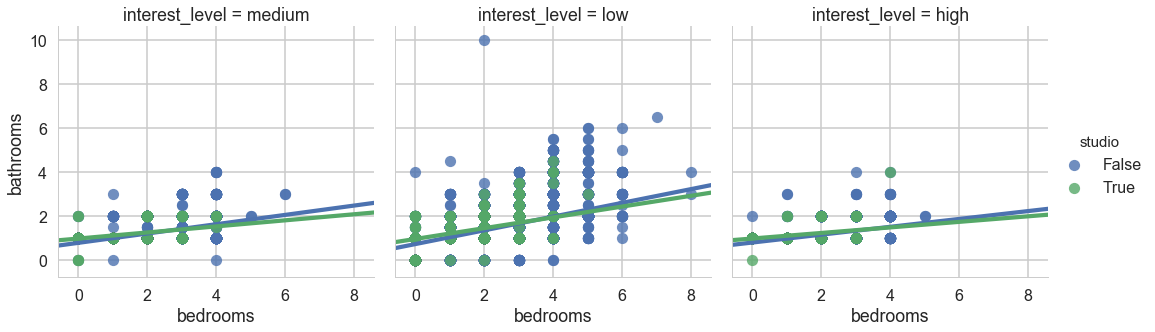

In [39]:
sns.lmplot(col='interest_level',x='bedrooms', y='bathrooms', data=df, ci=None, hue='studio')

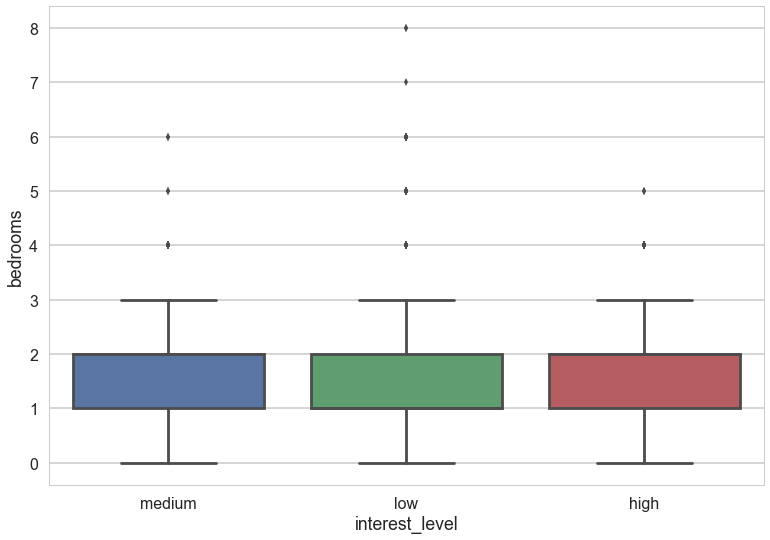

In [11]:
# Side by Side Box Plot of Bedrooms vs. High, Medium, and Low Interest
sns.boxplot(x=df['interest_level'], y=df['bedrooms'])

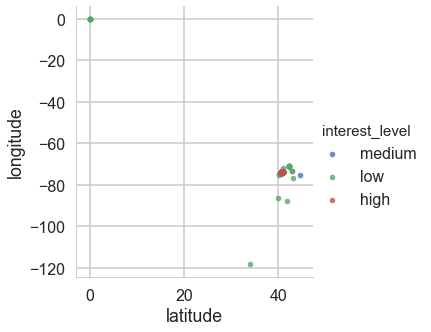

In [14]:
# See if geographical location affects interest level
sns.lmplot(x="latitude", y="longitude", hue="interest_level", data=df, fit_reg=False, legend=True, markers='.')

Those points are plotted at the (lat, long) of (0, -120). This is the standard return of googlemap's api if it cannot find the address due to formatting. Therefore, we should drop them.

In [71]:
# Drop outliers
outRem = df[df['latitude'] > 5]
outRem = outRem[outRem['longitude'] > -110]

(-75.0, -72.5)

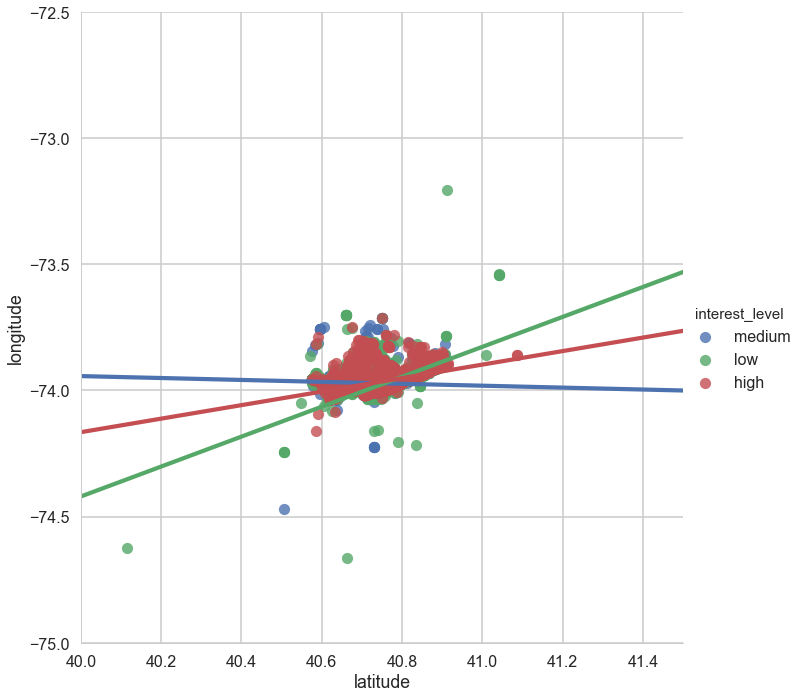

In [73]:
# Listing Location (without Outliers) Hued by Interest Level
sns.lmplot(x='latitude', y='longitude', hue='interest_level', data = outRem, size=10, ci=False)
plt.xlim([40, 41.5])
plt.ylim([-75.0,-72.5])

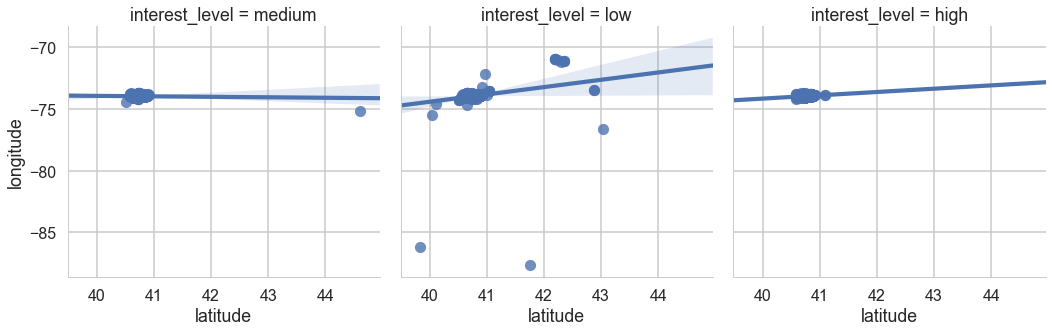

In [74]:
# Location Plotted on Separate Plots for Each Interest Level
sns.lmplot(x='latitude', y='longitude', col='interest_level', data = outRem)

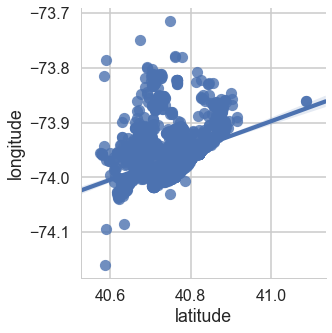

In [75]:
# Location of High Interest Listings
sns.lmplot(x='latitude', y='longitude', data = outRem[outRem['interest_level']=='high'])

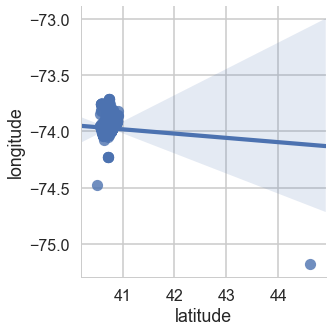

In [54]:
sns.lmplot(x='latitude', y='longitude', data = outRem[outRem['interest_level']=='medium'])

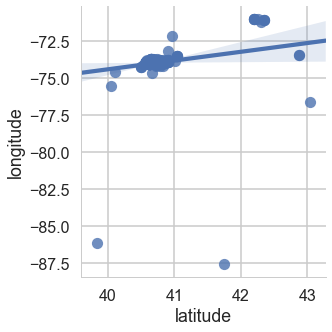

In [55]:
sns.lmplot(x='latitude', y='longitude', data = outRem[outRem['interest_level']=='low'])